In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
sb.set()
from datetime import datetime, timedelta
from ipywidgets import Checkbox
from matplotlib import rcParams
rcParams['figure.figsize'] = 10,6
import math
import scipy.stats
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings("ignore")

In [2]:
def dowload_data():
    
    # Stocks prices
    df = pd.read_csv('../DATA/PrepData.csv', date_parser=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # Choesen wallet
    weights = pd.read_csv('../DATA/choesenWallet.csv', index_col=False).drop('Unnamed: 0', axis=1).values[0]
    weights = np.round(weights,4)
    
    return weights, df
    
def prepare_data(investmentAmt, df, weights):
    
    # How many stock
    assetsQuant = len(df.columns)
    
    # Equal weights base on quantity of stock
    equal_weights = 1/len(df.columns)
    
    # How much inwested in singular stock base on chesen weights
    buyAmt = investmentAmt * weights
    
    # How much inwested in singular stock base on equal weights
    buyAmtEqual = investmentAmt * equal_weights
    
    # Period of analysis in mounths
    periodMonth = (df.index[-1].year - df.index[0].year) * 12 + (df.index[-1].month - df.index[0].month)
    
    # calculate cumulated returns
    retail_returns = df.pct_change(1).dropna()
    cum_returns = (1 + retail_returns).cumprod()
    
    # Let's save col names
    cols = cum_returns.columns
    
    # We want to see highest profitable stock alone
    highest_profit_ticker = cum_returns.iloc[-1].sort_values(ascending=False).index[0]
    cum_returns['highest_profitable_stock'] = cum_returns[highest_profit_ticker]*investmentAmt
    print(f'Highest profitable stocks is {highest_profit_ticker}')
    
    # Create new column which count cumulated value of portfolio with equal weights
    cum_returns['equalWeightedPortfolio'] = (cum_returns[cols]*buyAmtEqual).sum(axis=1)
    
    # Create new column which count cumulated value of portfolio with weights choesen in previous notebook
    cum_returns['YourPortfolio'] = (cum_returns[cols]*buyAmt).sum(axis=1)
        
    return cum_returns, buyAmt


def comparePortfolios_Plot(cum_returns, max_y = 1.2, freq=20):
    
    fig, ax = plt.subplots()

    # PLot equal weighted portfolio
    cum_returns.reset_index().plot(x = 'Date', y = 'equalWeightedPortfolio', ax = ax, alpha=0.7)

    # PLot your portfolio
    cum_returns.reset_index().plot(x = 'Date', y = 'YourPortfolio', ax = ax)
    
    # PLot your portfolio
    cum_returns.reset_index().plot(x = 'Date', y = 'highest_profitable_stock', ax = ax)
    
    # lets use log view on chart
    plt.yscale('log')

    # Set min, max and freq of y label
    max_ = cum_returns.iloc[-1].max()
    plt.yticks(np.arange(investmentAmt, max_*max_y, investmentAmt*freq))

    # Format Y labels to be more readable for user
    y_value=['{:,.0f}'.format(x).replace(",", " ") + ' USD' for x in ax.get_yticks()]
    ax.set_yticklabels(y_value);
    
    print('If frequency of y label is too high, just increase freq paramiter')
    
    return plt.show()

In [3]:
def calculate_proportions(cum_returns, df,weights):

    # copy cymulated returns. Only tickers. cum_rets contain also total value, etc.
    prop = cum_returns.iloc[:, 0:len(df.columns)]
    
    # create data frame with index equal cum_rets index. Index is dates 
    proportions = pd.DataFrame(index=prop.index, columns=prop.columns.values)

    # In range len of df loop and calculate current weight for each day
    for i in range(len(prop.columns)):
        # multiplay 
        proportions.iloc[:,i] = prop.iloc[:,i]*weights[i] / np.sum(prop*weights, axis=1)*100
    
    return proportions

def plot_proportions(proportions):
    
    proportions.plot()
    
    return plt.show()

In [4]:
def choese_rebalancing_frquency(quaterly, yearly):
    freqs = [quaterly, yearly]
    choesen_frq = []

    for freq in freqs:

        if freq.get_interact_value() == True:
            freq_name = freq.description
            choesen_frq.append(freq_name)

        else:
            pass

    # Condition: User must select 1 of the wallet
    if len(choesen_frq) == 0:
        print('You must select at least 1 frequency')
    
    elif len(choesen_frq) > 1:
        print('You CAN NOT select more than 1 frequency at one time')
        
    else: 
        print(f'Your choesen frequency: {choesen_frq}')
        
    return choesen_frq

In [5]:
def create_dates_for_rebalancing(df, frequency='yearly'):
    
    start = df.index[0]
    
    if frequency =='quaterly':

        # How many quaters in period
        quaters = (len(df)/365)*4
        # Number of months i one quater multiplyed by quaters
        quantity = np.floor(quaters*3).astype(int)
        rebalancing_dates = []
        for i in range(3, quantity, 3):
            rebalancing_dates.append(start + relativedelta(months=i))
            
        print(f'In this period you could make {np.floor(quantity/3).astype(int)} rebalancing')

    elif frequency =='yearly':

        years = len(df)/365
        quantity = np.floor(years+1).astype(int) # I add one becouse we start after first year in loop
        rebalancing_dates = []

        for i in range(1,quantity):      

            # Add i year from first transaction
            rebalancing_dates.append(start + relativedelta(years=i))
            
        print(f'In this period you could make {quantity-1} rebalancing')

    else:
        print('You must select period of frequency')

    # Contain restults in 1 D array
    rebalancing_dates = np.array(rebalancing_dates)
    
    return rebalancing_dates

In [6]:
def calculate_new_proportions(portfolio_value):
    
    # We need to count proportion for each stock again
    new_proportions = pd.DataFrame(index=portfolio_value.index, columns=portfolio_value.columns.values)

    # Loop by new portfolio value and count new prop
    for i in range(len(portfolio_value.columns)):

        new_proportions.iloc[:,i] = portfolio_value.iloc[:,i]*100 / np.sum(portfolio_value, axis=1)
        
    return new_proportions

In [7]:
def calc_portfolio_value_by_date(portfolio_value, new_proportions, rebalancing_dates, weights, i):
    
    # That is how portfolio balance look like in chacking period
    check_day_prop = new_proportions.loc[[rebalancing_dates[i]]][new_proportions.columns].values

    # That is how we sould multiply our proportion to get proper one
    multiplier = weights*100/check_day_prop

    # It contains data year befor rebalancing date, which do not need to change anth
    previos_period = portfolio_value.loc[:rebalancing_dates[i]]

    # It contains data after Rebalancing with new prop proportion
    next_period = portfolio_value.loc[rebalancing_dates[i] + relativedelta(days=1):]*multiplier

    # Portfolio value in time with new wages
    portfolio_value = pd.concat([previos_period, next_period])
    
    return portfolio_value

In [8]:
def rebalancing_model_over_period(rebalancing_dates, buyAmt, cum_returns, proportions, calc_portfolio_value_by_date, calculate_new_proportions):
    
    # This is the value of the portfolio from cumulated return multiplyed by buy Amount
    portfolio_value = cum_returns.iloc[:,:len(buyAmt)]*buyAmt
    
    # copy old proportions. New will be overwrtited
    new_proportions = proportions
    
    
    # Loop throw rabalancing dates and make changes if necessery
    for i in range(len(rebalancing_dates)):
        
        # Function that calulates portfolio values over all period
        portfolio_value = calc_portfolio_value_by_date(portfolio_value, new_proportions, rebalancing_dates, weights, i)
        
        # Function that calculate new proportions base on new portfolio vales in period
        new_proportions = calculate_new_proportions(portfolio_value)
        
    return portfolio_value, new_proportions

In [9]:
def calc_portfolio_value_by_row(new_proportions, portfolio_value, weights, i):
    
    # Take proportion of all asets in choesen period
    check_day_prop = new_proportions.iloc[i].values

    # That is how we sould multiply our proportion to get proper one
    multiplier = weights*100/check_day_prop

     # It contains data year befor rebalancing date, which do not need to change anth
    previos_period = portfolio_value.iloc[:i]

    # It contains data after Rebalancing with new prop proportion
    next_period = portfolio_value.iloc[i:]*multiplier

    # Portfolio value in time with new wages
    portfolio_value = pd.concat([previos_period, next_period])
    
    return portfolio_value

In [46]:
def rebalancing_model_over_margin(selection,buyAmt, cum_returns, proportions, weights, calc_portfolio_value_by_row, calculate_new_proportions):
    
    # Format margin type to float number
    margin = float(selection)
    
    # if margin is 20% it means that asset must increase to 120% of it's value or decrease to 80% of it's value 
    up_margin = (1 + margin) * 100
    low_margin = (1 - margin) * 100

    # Margin paramiters
    max_weights = weights * up_margin
    min_weights = weights * low_margin

    # Set first iterator as 0
    i = 0

    # Portfolio without rebalancing. It'll be owerrited
    portfolio_value = cum_returns.iloc[:,:5]*buyAmt

    # copy old proportions. New will be overwrtited
    new_proportions = proportions
    
    counter = 0

    while i < len(proportions)-1:

        # add 1 to iterator in each sequence of the loop
        i+=1

         # iterate by all columns (assets)
        for k in range(len(proportions.columns)):

            # If proportions are over the margin then: do rebalancing
            if new_proportions.iloc[i,k] < min_weights[k] or new_proportions.iloc[i,k] > max_weights[k]:
                
                # Functions that calculates value of portfolio by choesen row
                portfolio_value = calc_portfolio_value_by_row(new_proportions, portfolio_value, weights, i)

                # Function that calculates proportion base on portfolio value
                new_proportions = calculate_new_proportions(portfolio_value)
                
                counter+=1

                # We break the k loop. We do not need to check other assets, becouse if any is over the margin we do reb anyway
                break

            else:
                pass
            
    print(f'The algorithm did {counter} rebalancing')

    return new_proportions, portfolio_value


In [11]:
def compare_balance_portfolio_vs_previous(portfolio_value, cum_returns, max_y = 1.1, freq=5):
    
    # Sum of singular portfolio values in each period of analysis
    portfolio_value['BalancedPortfolio'] = np.sum(portfolio_value, axis=1)

    fig, ax = plt.subplots()

    # PLot equal weighted portfolio
    cum_returns.reset_index().plot(x = 'Date', y = 'equalWeightedPortfolio', ax = ax, alpha=0.7)

    # PLot your portfolio
    cum_returns.reset_index().plot(x = 'Date', y = 'YourPortfolio', ax = ax)

    # PLot your portfolio
    portfolio_value.reset_index().plot(x = 'Date', y = 'BalancedPortfolio', ax = ax)

    # lets use log view on chart
    plt.yscale('log')

    # Set min, max and freq of y label
    max_ = cum_returns.drop('highest_profitable_stock', axis=1).iloc[-1].max()
    plt.yticks(np.arange(investmentAmt, max_*max_y, investmentAmt*freq))

    # Format Y labels to be more readable for user
    y_value=['{:,.0f}'.format(x).replace(",", " ") + ' USD' for x in ax.get_yticks()]
    ax.set_yticklabels(y_value);
    
    print('If frequency of y label is too high, just increase freq paramiter')

    return plt.show()

In [19]:
def choese_rebalancing_method(period, margin):
    methods = [period, margin]
    choesen_method = []

    for method in methods:

        if method.get_interact_value() == True:
            method_name = method.description
            choesen_method.append(method_name)

        else:
            pass

    # Condition: User must select 1 of the wallet
    if len(choesen_method) == 0:
        print('You must select at least 1 frequency')
    
    elif len(choesen_method) > 1:
        print('You CAN NOT select more than 1 frequency at one time')
        
    else: 
        print(f'Your choesen frequency: {choesen_method}')
        
    return choesen_method

In [58]:
def display_next_options(choesen_method):
    if choesen_method == ['Over choesen period']:

        print('Select frequency of rebalancing:')
        selection = display(quaterly, yearly)
    else:
        print('Select margin of rebalancing:')
        selection = input()
        
    return selection

In [76]:
def run_selected_rebalancing_method(choesen_method, weights, buyAmt, cum_returns, proportions,rebalancing_model_over_period, rebalancing_model_over_margin, selection, calc_portfolio_value_by_date,calc_portfolio_value_by_row, calculate_new_proportions):
    
    if choesen_method == ['Over choesen period']:

        choesen_frq = choese_rebalancing_frquency(quaterly, yearly)
        rebalancing_dates = create_dates_for_rebalancing(df, frequency=choesen_frq[0])
        portfolio_value, new_proportions = rebalancing_model_over_period(rebalancing_dates, buyAmt, cum_returns, proportions, calc_portfolio_value_by_date, calculate_new_proportions)

    else:
        new_proportions, portfolio_value = rebalancing_model_over_margin(selection,buyAmt, cum_returns, proportions, weights, calc_portfolio_value_by_row, calculate_new_proportions)
        
    return new_proportions, portfolio_value

In [29]:
def compare_balance_portfolio_vs_previous(portfolio_value, cum_returns, max_y = 1.1, freq=5):
    
    # Sum of singular portfolio values in each period of analysis
    portfolio_value['BalancedPortfolio'] = np.sum(portfolio_value, axis=1)

    fig, ax = plt.subplots()

    # PLot equal weighted portfolio
    cum_returns.reset_index().plot(x = 'Date', y = 'equalWeightedPortfolio', ax = ax, alpha=0.7)

    # PLot your portfolio
    cum_returns.reset_index().plot(x = 'Date', y = 'YourPortfolio', ax = ax)

    # PLot your portfolio
    portfolio_value.reset_index().plot(x = 'Date', y = 'BalancedPortfolio', ax = ax)

    # lets use log view on chart
    plt.yscale('log')

    # Set min, max and freq of y label
    max_ = cum_returns.drop('highest_profitable_stock', axis=1).iloc[-1].max()
    plt.yticks(np.arange(investmentAmt, max_*max_y, investmentAmt*freq))

    # Format Y labels to be more readable for user
    y_value=['{:,.0f}'.format(x).replace(",", " ") + ' USD' for x in ax.get_yticks()]
    ax.set_yticklabels(y_value);
    
    print('If frequency of y label is too high, just increase freq paramiter')

    return plt.show()

In [12]:
weights, df = dowload_data()

In [13]:
investmentAmt = 100000

In [14]:
cum_returns, buyAmt = prepare_data(investmentAmt, df, weights)

Highest profitable stocks is BTC-USD


If frequency of y label is too high, just increase freq paramiter


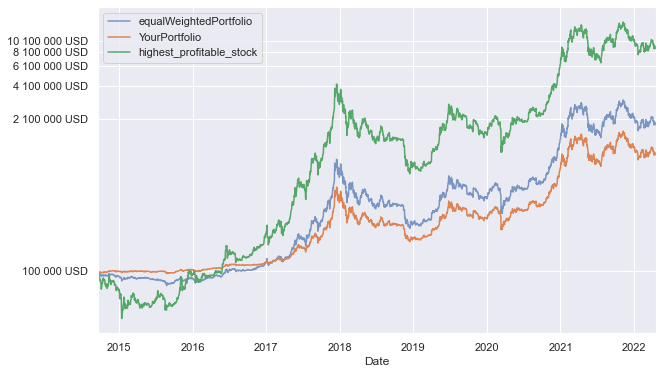

In [15]:
comparePortfolios_Plot(cum_returns);

### Calc prop

In [16]:
proportions = calculate_proportions(cum_returns, df,weights)

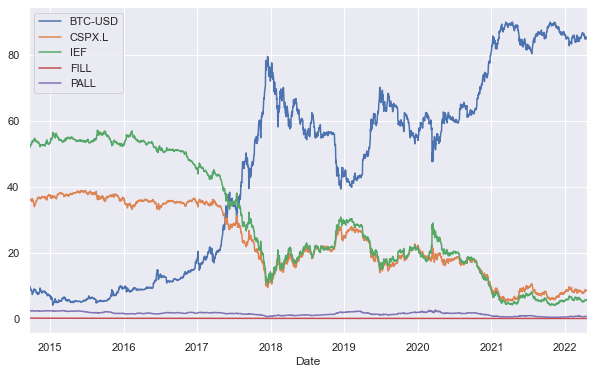

In [17]:
plot_proportions(proportions)

In [18]:
quaterly = Checkbox(description = 'quaterly')
yearly = Checkbox(description = 'yearly')

### How would you like to rebalance your portfolio?

In [20]:
period = Checkbox(description = 'Over choesen period')
margin = Checkbox(description = 'Over choesen margin')

In [21]:
display(period, margin)

Checkbox(value=False, description='Over choesen period')

Checkbox(value=False, description='Over choesen margin')

In [74]:
choesen_method = choese_rebalancing_method(period, margin)

Your choesen frequency: ['Over choesen period']


In [75]:
selection = display_next_options(choesen_method)

Select frequency of rebalancing:


Checkbox(value=True, description='quaterly')

Checkbox(value=False, description='yearly')

In [77]:
new_proportions, portfolio_value = run_selected_rebalancing_method(choesen_method, weights, buyAmt, cum_returns, proportions,rebalancing_model_over_period, rebalancing_model_over_margin, selection, calc_portfolio_value_by_date,calc_portfolio_value_by_row, calculate_new_proportions)

Your choesen frequency: ['yearly']
In this period you could make 7 rebalancing


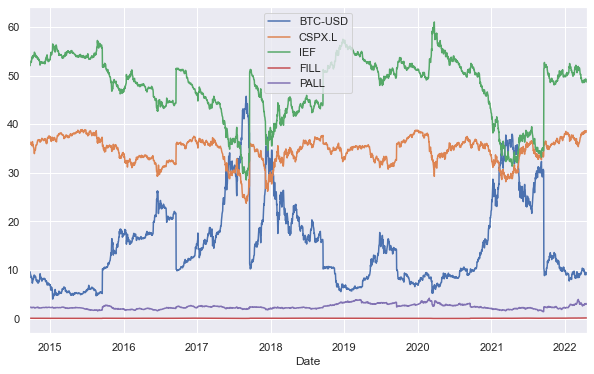

In [78]:
plot_proportions(new_proportions)

If frequency of y label is too high, just increase freq paramiter


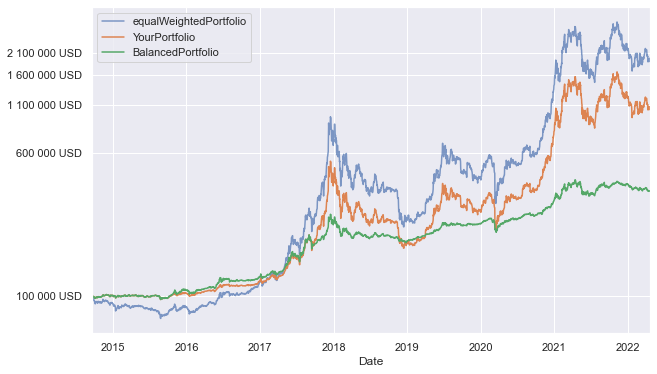

In [79]:
compare_balance_portfolio_vs_previous(portfolio_value, cum_returns, max_y = 1.1, freq=5)

If frequency of y label is too high, just increase freq paramiter


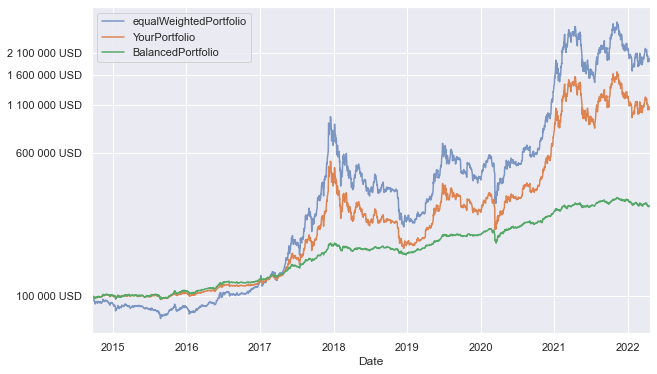

In [30]:
compare_balance_portfolio_vs_previous(portfolio_value, cum_returns, max_y = 1.1, freq=5)

In [ ]:
buy